# New York City K-12 School Analysis

- Data acquired from [greatschools.org](https://www.greatschools.org/new-york/new-york/schools/)

In [1]:
import pandas as pd
import numpy as np
import json
import itertools
import re

## Data Preprocessing

### -  Import data

In [2]:
raw_data = pd.read_csv('Schools.csv')

In [3]:
raw_data.head(3)

,grades_served,gs_rating_academics,gs_rating_overall,info,name,review_count,school_type,test_scores
0,K-4,Test scores:10;Student progress:9,10.0,"{""@context"":""https://schema.org"",""@type"":""Scho...",Success Academy Upper West,37 reviews,Public charter,Math:98%:43%;Grade 3:98%:44%;Grade 4:98%:45%;G...
1,6-12,Test scores:9;College readiness:10;Student pro...,9.0,"{""@context"":""https://schema.org"",""@type"":""Scho...",Columbia Secondary School,31 reviews,Public district,Algebra I:67%:31%;Geometry:52%:22%;English:96%...
2,6,Test scores:9;Student progress:10;Advanced cou...,9.0,"{""@context"":""https://schema.org"",""@type"":""Scho...",YORKVILLE EAST MIDDLE SCHOOL,4 reviews,Public district,English:51%:34%;Grade 6:46%:34%;Grade 7:59%:35...


In [4]:
raw_data = raw_data.rename(columns = {'info':'information'})

In [5]:
raw_data.dtypes

grades_served           object
gs_rating_academics     object
gs_rating_overall      float64
information             object
name                    object
review_count            object
school_type             object
test_scores             object
dtype: object

In [6]:
raw_data.shape

(1121, 8)

### - Extract key academic performance indicators

In [7]:
# This function returns a dictionary each (key, value) pair corresponding to (indicator, rating)
def preprocess_gs_rating_academics(s):
    step1 = s.split(';') # split into list of indicator:rating strings
    d = dict()
    for s in step1:
        current_item = s.replace(' ', '_').split(':')
        try:
            d['gs_rating_' + current_item[0]] = int(current_item[1])
        except:
            d['gs_rating_' + current_item[0]] = np.nan
    return d

In [8]:
raw_data.gs_rating_academics = \
raw_data.gs_rating_academics.map(preprocess_gs_rating_academics, na_action='ignore')
raw_data.head(1)

,grades_served,gs_rating_academics,gs_rating_overall,information,name,review_count,school_type,test_scores
0,K-4,"{'gs_rating_Test_scores': 10, 'gs_rating_Stude...",10.0,"{""@context"":""https://schema.org"",""@type"":""Scho...",Success Academy Upper West,37 reviews,Public charter,Math:98%:43%;Grade 3:98%:44%;Grade 4:98%:45%;G...


In [9]:
# get a list of unique indicators
indicators = raw_data.gs_rating_academics.map(lambda d:list(d.keys()), na_action='ignore').dropna().tolist()
indicators = set(itertools.chain(*indicators))
indicators

{'gs_rating_Advanced_courses',
 'gs_rating_College_readiness',
 'gs_rating_Student_progress',
 'gs_rating_Test_scores'}

In [10]:
# create a column for each of the indicators
for indicator in indicators:
    raw_data[indicator] = \
    raw_data.gs_rating_academics.map(lambda d:d[indicator] \
                             if indicator in d else np.nan, na_action = 'ignore')

### -  Extract test scores

In [11]:
# This function returns a dictionary each (key, value) pair corresponding to either (proficiency, percentage) or 
# (state average, percentage) of a subject 
def preprocess_test_scores(s):
    step1 = s.split(';') # split into list of subject:proficiency:grade strings
    subject = 'placeholder'
    d = dict()
    for s in step1:
        current_item = s.replace(' ', '_').split(':')

        if re.search('^Grade', current_item[0]) == None:
            subject = current_item[0]
            proficiency_key = subject + '_proficiency'
            state_avg_key = subject + '_state_avg'
        else:
            proficiency_key = subject + '_' + current_item[0] + '_proficiency'
            state_avg_key = subject + '_' + current_item[0] + '_state_avg'

        proficiency = re.search('([0-9]+)%',current_item[1])
        if proficiency != None:
            proficiency = float(proficiency.group(1))/100
        else:
            proficiency = np.nan

        state_avg = re.search('([0-9]+)%',current_item[2])
        if state_avg != None:
            state_avg = float(state_avg.group(1))/100
        else:
            state_avg = np.nan
        
        d[proficiency_key] = proficiency
        d[state_avg_key] = state_avg

    return d

In [12]:
raw_data.test_scores = \
raw_data.test_scores.map(preprocess_test_scores, na_action='ignore')

In [13]:
# get a list of unique subjects
test_score_indicators = raw_data.test_scores.map(lambda d:list(d.keys()), na_action='ignore').dropna().tolist()
test_score_indicators = set(itertools.chain(*test_score_indicators))

In [14]:
for test_score_indicator in test_score_indicators:
    raw_data[test_score_indicator] = \
    raw_data.test_scores.map(lambda d:d[test_score_indicator] \
                             if test_score_indicator in d else np.nan, na_action = 'ignore')

In [15]:
pd.options.display.max_columns = 100

In [16]:
raw_data.head(1)

,grades_served,gs_rating_academics,gs_rating_overall,information,name,review_count,school_type,test_scores,gs_rating_Student_progress,gs_rating_Test_scores,gs_rating_College_readiness,gs_rating_Advanced_courses,Math_Grade_8_state_avg,Algebra_II_proficiency,English_Grade_8_state_avg,Math_Grade_5_state_avg,English_Grade_5_proficiency,English_Grade_5_state_avg,Biology_I_state_avg,Algebra_II_state_avg,Chemistry_state_avg,Biology_I_proficiency,Math_Grade_4_proficiency,English_Grade_7_state_avg,Integrated_Algebra_state_avg,Geometry_state_avg,Earth_Science_proficiency,US_History_and_Government_proficiency,Algebra_I_proficiency,Chemistry_proficiency,Math_Grade_4_state_avg,Math_Grade_8_proficiency,US_History_and_Government_state_avg,Math_Grade_3_proficiency,English_Grade_4_proficiency,English_Grade_3_state_avg,Algebra_I_state_avg,English_Grade_6_state_avg,Geometry_proficiency,Algebra2/Trigonometry_proficiency,Math_state_avg,Math_proficiency,Physics_proficiency,Math_Grade_3_state_avg,Math_Grade_7_proficiency,Math_Grade_7_state_avg,English_state_avg,Math_Grade_6_proficiency,Algebra2/Trigonometry_state_avg,English_Grade_7_proficiency,Global_History_and_Geography_state_avg,English_Grade_4_state_avg,Integrated_Algebra_proficiency,Math_Grade_5_proficiency,English_Grade_8_proficiency,English_proficiency,Physics_state_avg,English_Grade_3_proficiency,English_Grade_6_proficiency,Math_Grade_6_state_avg,Earth_Science_state_avg,Global_History_and_Geography_proficiency
0,K-4,"{'gs_rating_Test_scores': 10, 'gs_rating_Stude...",10.0,"{""@context"":""https://schema.org"",""@type"":""Scho...",Success Academy Upper West,37 reviews,Public charter,"{'Math_proficiency': 0.98, 'Math_state_avg': 0...",9.0,10.0,NaN,NaN,NaN,NaN,NaN,0.4,0.87,0.33,NaN,NaN,NaN,NaN,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,NaN,NaN,0.98,0.88,0.42,NaN,NaN,NaN,NaN,0.43,0.98,NaN,0.44,NaN,NaN,0.39,NaN,NaN,NaN,NaN,0.41,NaN,0.98,NaN,0.9,NaN,0.94,NaN,NaN,NaN,NaN


### -  Extract reviews
Extract school address and aggregate review stats

In [17]:
raw_data.information = \
raw_data.information.map(json.loads)

In [18]:
# pick data of interest from the information column
raw_data['address'] = raw_data.information.map(lambda d:d['address'])
raw_data['aggregateRating'] = raw_data.information.map(lambda d:d['aggregateRating'] \
                                                       if 'aggregateRating' in d.keys() else None)
raw_data['review'] = raw_data.information.map(lambda d:d['review'] \
                                                       if 'review' in d.keys() else None)

In [19]:
# parse address
raw_data['streetAddress'] = raw_data.address.map(lambda d:d['streetAddress'])
raw_data['addressLocality'] = raw_data.address.map(lambda d:d['addressLocality'])
raw_data['addressRegion'] = raw_data.address.map(lambda d:d['addressRegion'])
raw_data['postalCode'] = raw_data.address.map(lambda d:d['postalCode'])

# parse aggregate review stats
raw_data['bestRating'] = raw_data.aggregateRating.map(lambda d:d['bestRating'] \
                                                       if 'bestRating' in d.keys() else np.nan, na_action='ignore')
raw_data['ratingCount'] = raw_data.aggregateRating.map(lambda d:d['ratingCount'] \
                                                       if 'ratingCount' in d.keys() else np.nan, na_action='ignore')
raw_data['ratingValue'] = raw_data.aggregateRating.map(lambda d:d['ratingValue'] \
                                                       if 'ratingValue' in d.keys() else np.nan, na_action='ignore')
raw_data['reviewCount'] = raw_data.aggregateRating.map(lambda d:d['reviewCount'] \
                                                       if 'reviewCount' in d.keys() else np.nan, na_action='ignore')
raw_data['worstRating'] = raw_data.aggregateRating.map(lambda d:d['worstRating'] \
                                                       if 'worstRating' in d.keys() else np.nan, na_action='ignore')

In [30]:
df_schools = raw_data.drop(['gs_rating_academics','information','test_scores',
                           'address','aggregateRating','review', 'review_count'], axis = 1)
df_schools.dtypes

grades_served                                object
gs_rating_overall                           float64
name                                         object
school_type                                  object
gs_rating_Student_progress                  float64
gs_rating_Test_scores                       float64
gs_rating_College_readiness                 float64
gs_rating_Advanced_courses                  float64
Math_Grade_8_state_avg                      float64
Algebra_II_proficiency                      float64
English_Grade_8_state_avg                   float64
Math_Grade_5_state_avg                      float64
English_Grade_5_proficiency                 float64
English_Grade_5_state_avg                   float64
Biology_I_state_avg                         float64
Algebra_II_state_avg                        float64
Chemistry_state_avg                         float64
Biology_I_proficiency                       float64
Math_Grade_4_proficiency                    float64
English_Grad

Extract individual review data

In [21]:
def processReviews(review_list, school_index):
    reviewer = []
    review_date = []
    review_text = []
    review_rating_value = []
    
    for review in review_list:
        try:
            ra = review['author']
        except:
            ra = None
        reviewer.append(ra)
        
        try:
            rd = review['datePublished']
        except:
            rd = None
        review_date.append(rd)
        
        try:
            rt = review['reviewBody']
        except:
            rt = None
        review_text.append(rt)
        
        try:
            rv = int(review['reviewRating']['ratingValue'])
        except:
            rv = np.nan
        review_rating_value.append(rv)
        
    return pd.DataFrame({'reviewer':reviewer,
                         'review_date':review_date,
                         'review_text':review_text,
                         'review_rating_value':review_rating_value}, index = [school_index]*len(review_list) )

In [22]:
df_reviews = raw_data.loc[:,'review'].dropna()

idx = df_reviews.index # save index so reviews can be joined back with school level info

df_reviews = map(processReviews, df_reviews, idx) # return one dataframe per school where each row corresponds to
                                                  # a single review 

df_reviews = pd.concat(df_reviews)

df_reviews = pd.merge(df_reviews, df_schools, left_index = True, right_index = True) # join with school level info

## Analysis

First I'd like to examine rating distributions and see if it's consistent across differences school types and stakeholders

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df_reviews['review_rating_value_adj'] = df_reviews['review_rating_value'] + \
np.random.uniform(-.5, .5, len(df_reviews)) # add jitter to ratings in order to smooth out density curves

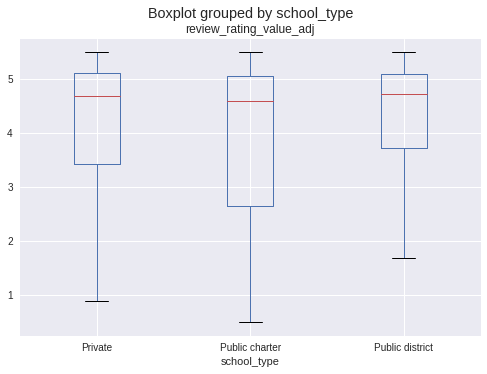

In [31]:
df_reviews.boxplot(by='school_type', column='review_rating_value_adj')

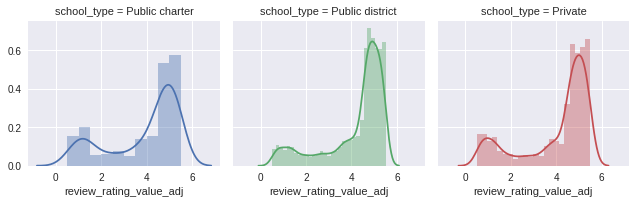

In [24]:
ratingGrid1 = sns.FacetGrid(df_reviews, col='school_type', hue='school_type')
ratingGrid1.map(sns.distplot,'review_rating_value_adj')

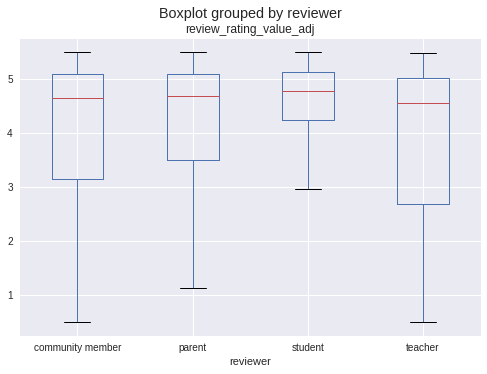

In [33]:
df_reviews[df_reviews['reviewer'] != 'school leader'].boxplot(by='reviewer', column='review_rating_value_adj')

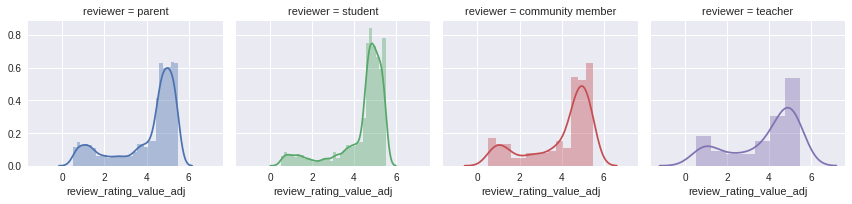

In [25]:
ratingGrid2 = sns.FacetGrid(df_reviews[df_reviews['reviewer'] != 'school leader'], col='reviewer', hue='reviewer')
ratingGrid2.map(sns.distplot,'review_rating_value_adj')

Second I'd like to see if greatschools.org ratings are consistent with that of the community

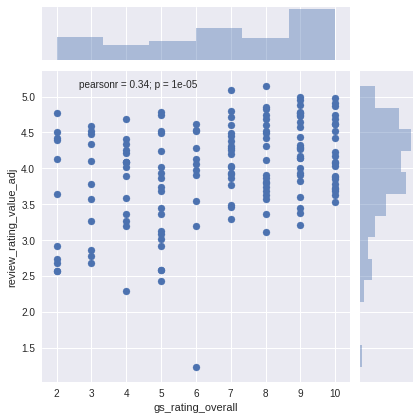

In [26]:
df_reviews_copy = df_reviews.copy() #        

df_reviews_copy.reset_index(inplace=True)

sample_size_filter = df_reviews_copy.groupby('index').size()>=10

scatter_data = df_reviews_copy.groupby('index').agg({'gs_rating_overall':'max','review_rating_value_adj':'mean'})

scatter_data = scatter_data.loc[sample_size_filter,:]

sns.jointplot(scatter_data.gs_rating_overall,scatter_data.review_rating_value_adj)

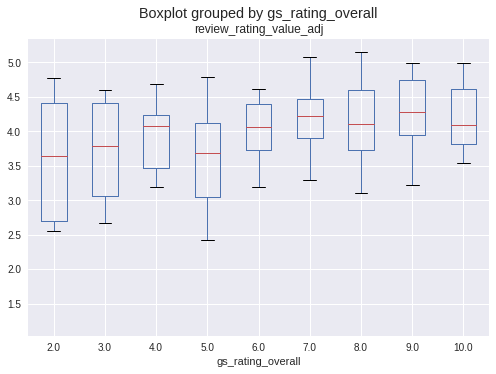

In [28]:
scatter_data.boxplot(by='gs_rating_overall', column='review_rating_value_adj')

/home/yongguang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


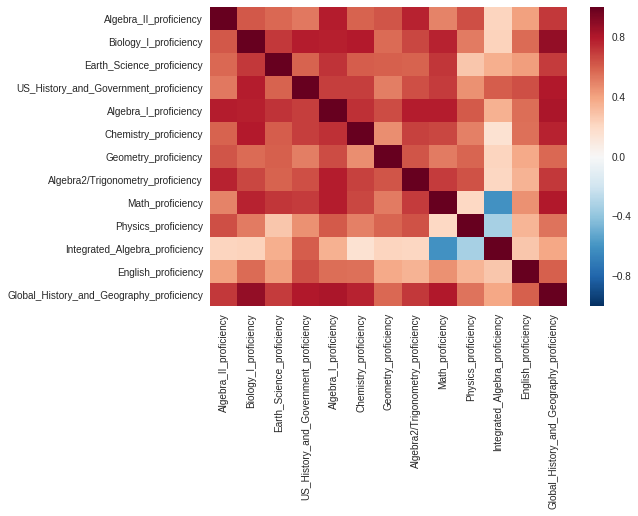

In [27]:
df_schools_reduced = df_schools.loc[df_schools['grades_served'].str.contains('(11)|(12)'),] # filter on high schools

cols_selector = np.logical_and(np.logical_and(
    df_schools_reduced.columns.str.endswith('proficiency'), # interested in proficiency columns
    ~df_schools_reduced.columns.str.contains('Grade')       # but not individual grade level
),~np.all(pd.isnull(df_schools_reduced), axis=0))           # additionally, filter out columns with no data

corr = df_schools_reduced.loc[:,cols_selector].corr()
sns.heatmap(corr)

In [ ]:
df_schools_reduced = df_schools.loc[df_schools['grades_served'].str.contains('[6-8]'),]

cols_selector = np.logical_and(np.logical_and(
    df_schools_reduced.columns.str.endswith('proficiency'),
    ~df_schools_reduced.columns.str.contains('Grade')
),~np.all(pd.isnull(df_schools_reduced), axis=0))

corr = df_schools_reduced.loc[:,cols_selector].corr()
sns.heatmap(corr)